In [6]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

In [7]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("data/train.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("data/test.csv")

# preview train data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
print('El número de muestras en los datos del tren es {}.'.format(train_df.shape[0]))

El número de muestras en los datos del tren es 891.


In [9]:
# preview test data
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
print('El número de muestras en los datos de la prueba es {}.'.format(test_df.shape[0]))

El número de muestras en los datos de la prueba es 418.


2. Calidad de los datos y evaluación del valor perdido

In [11]:
# comprobar los valores faltantes en los datos del tren
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

2.1. Edad: valores faltantes

In [12]:
# percent of missing "Age" 
print('El porcentaje de registros de "Edad" que faltan es %.2f%%' %((train_df['Age'].isnull().sum()/train_df.shape[0])*100))

El porcentaje de registros de "Edad" que faltan es 19.87%


Faltan ~20 % de las entradas sobre la edad de los pasajeros. Veamos cómo se ve la variable 'Edad' en general.

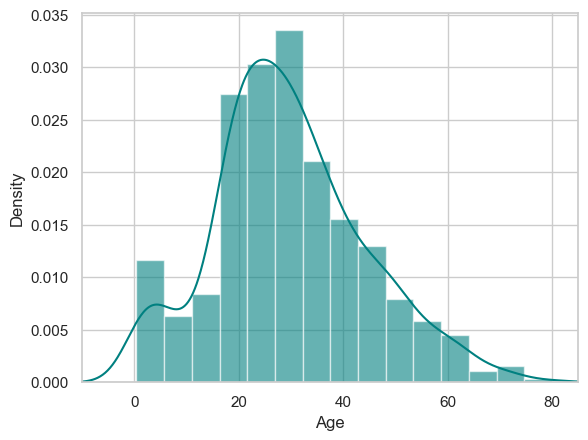

In [13]:
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Dado que "Edad" está sesgada (a la derecha), el uso de la media podría darnos resultados sesgados al completar edades mayores a las deseadas. Para solucionar esto, usaremos la mediana para imputar los valores faltantes.

In [14]:
# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

The mean of "Age" is 29.70
The median of "Age" is 28.00


2.2. Cabin - Missing Values

In [15]:
# percent of missing "Cabin" 
print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Cabin" records is 77.10%



Faltan el 77% de los registros, lo que significa que probablemente no sea prudente imputar información y utilizar esta variable para la predicción. Ignoraremos esta variable en nuestro modelo.

2.3. Embarked - Missing Values

In [16]:
# percent of missing "Embarked" 
print('Percent of missing "Embarked" records is %.2f%%' %((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


There are only 2 (0.22%) missing values for "Embarked", so we can just impute with the port where most people boarded.

Sólo faltan 2 (0,22%) valores para "Embarcado", por lo que podemos imputar simplemente el puerto donde embarcó la mayoría de las personas.

Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


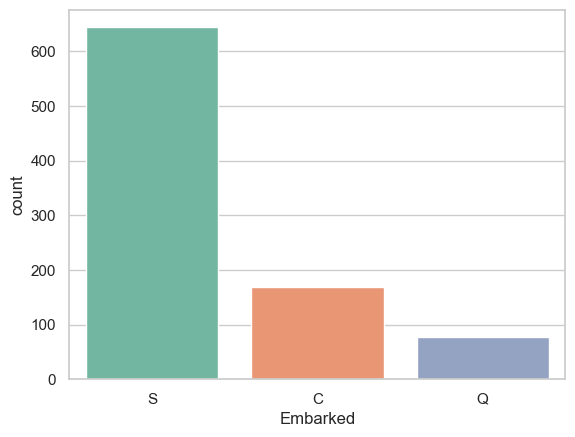

In [17]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()


2.4. Ajustes Finales a los Datos (Entrenamiento y Pruebas)
Según mi evaluación de los valores faltantes en el conjunto de datos, realizaré los siguientes cambios en los datos:

Si falta "Age" para una fila dada, lo imputaré con 28 (la mediana de la edad).
Si falta "Embarked" para una fila dada, lo imputaré con "S" (el puerto de embarque más común).
Ignoraré "Cabin" como una variable. Hay demasiados valores faltantes para la imputación. Según la información disponible, parece que este valor está asociado con la clase del pasajero y la tarifa pagada.

In [18]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [19]:
# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [20]:
# preview adjusted train data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


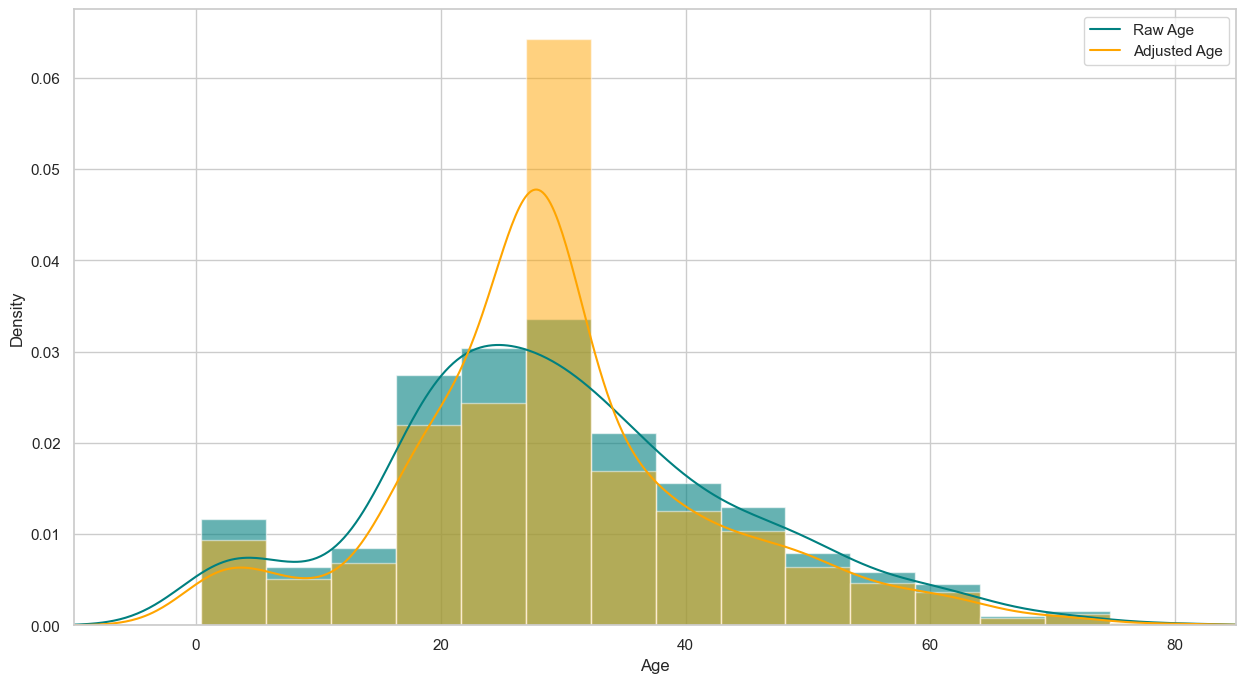

In [21]:
plt.figure(figsize=(15,8))
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()


2.4.1. Variables Adicionales
Según el diccionario de datos de Kaggle, tanto SibSp como Parch están relacionados con viajar con la familia. Por simplicidad (y para tener en cuenta la posible multicolinealidad), combinaré el efecto de estas variables en un predictor categórico: si esa persona viajaba sola o no.

In [22]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

También crearé variables categóricas para la Clase del Pasajero ("Pclass"), Género ("Sexo") y Puerto de Embarque ("Embarcado").

In [23]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,False,False,True,False,False,True,True
1,1,38.0,71.2833,0,True,False,False,True,False,False,False
2,1,26.0,7.9250,1,False,False,True,False,False,True,False
3,1,35.0,53.1000,0,True,False,False,False,False,True,False
4,0,35.0,8.0500,1,False,False,True,False,False,True,True



Ahora, aplicaré los mismos cambios a los datos de prueba (test).
Aplicaré la misma imputación para "Age" en los datos de prueba que hice en los datos de entrenamiento (si falta, Edad = 28).
También eliminaré la variable "Cabin" de los datos de prueba, ya que he decidido no incluirla en mi análisis.
No hubo valores faltantes en la variable del puerto de "Embarque".
Agregaré las variables ficticias (dummy variables) para finalizar el conjunto de prueba.
Finalmente, imputaré el valor faltante de "Tarifa" con la mediana, que es 14.45.

In [24]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [25]:
test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,False,False,True,False,True,False,True
1,47.0,7.0000,0,False,False,True,False,False,True,False
2,62.0,9.6875,1,False,True,False,False,True,False,True
3,27.0,8.6625,1,False,False,True,False,False,True,True
4,22.0,12.2875,0,False,False,True,False,False,True,False


In [26]:
3. Análisis de datos exploratorios  
3.1. Exploration of Age

SyntaxError: invalid syntax (667032899.py, line 1)

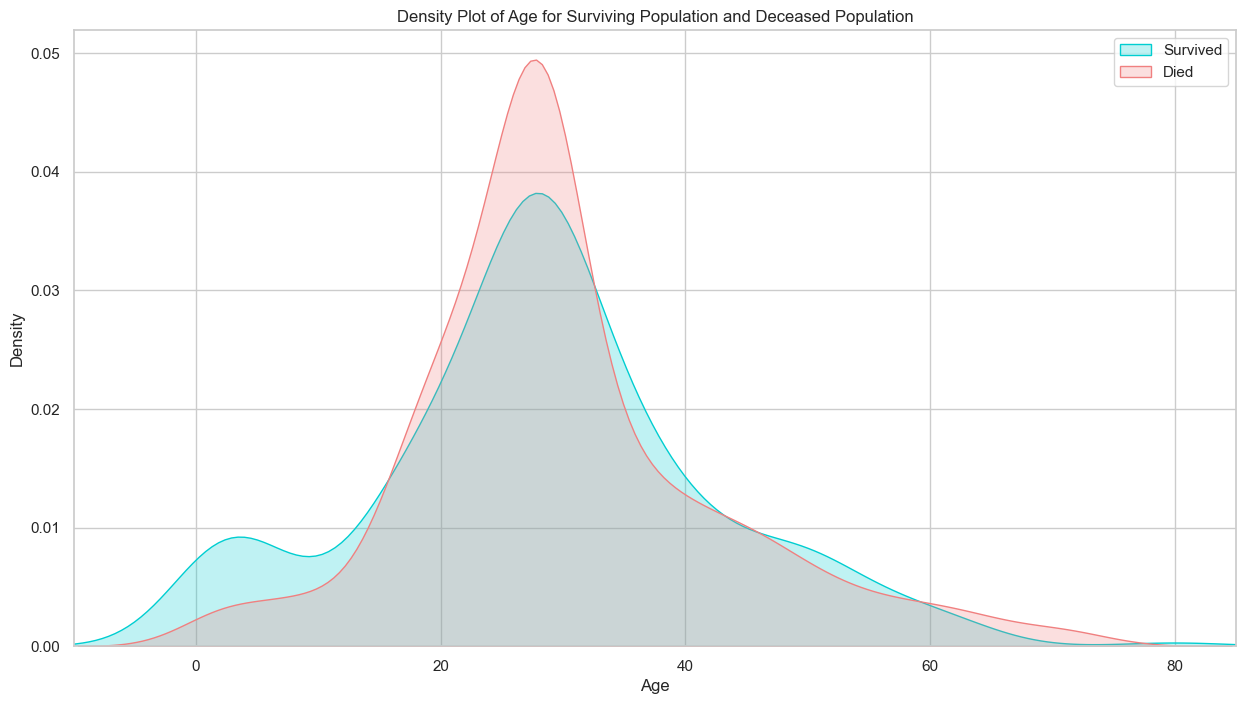

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

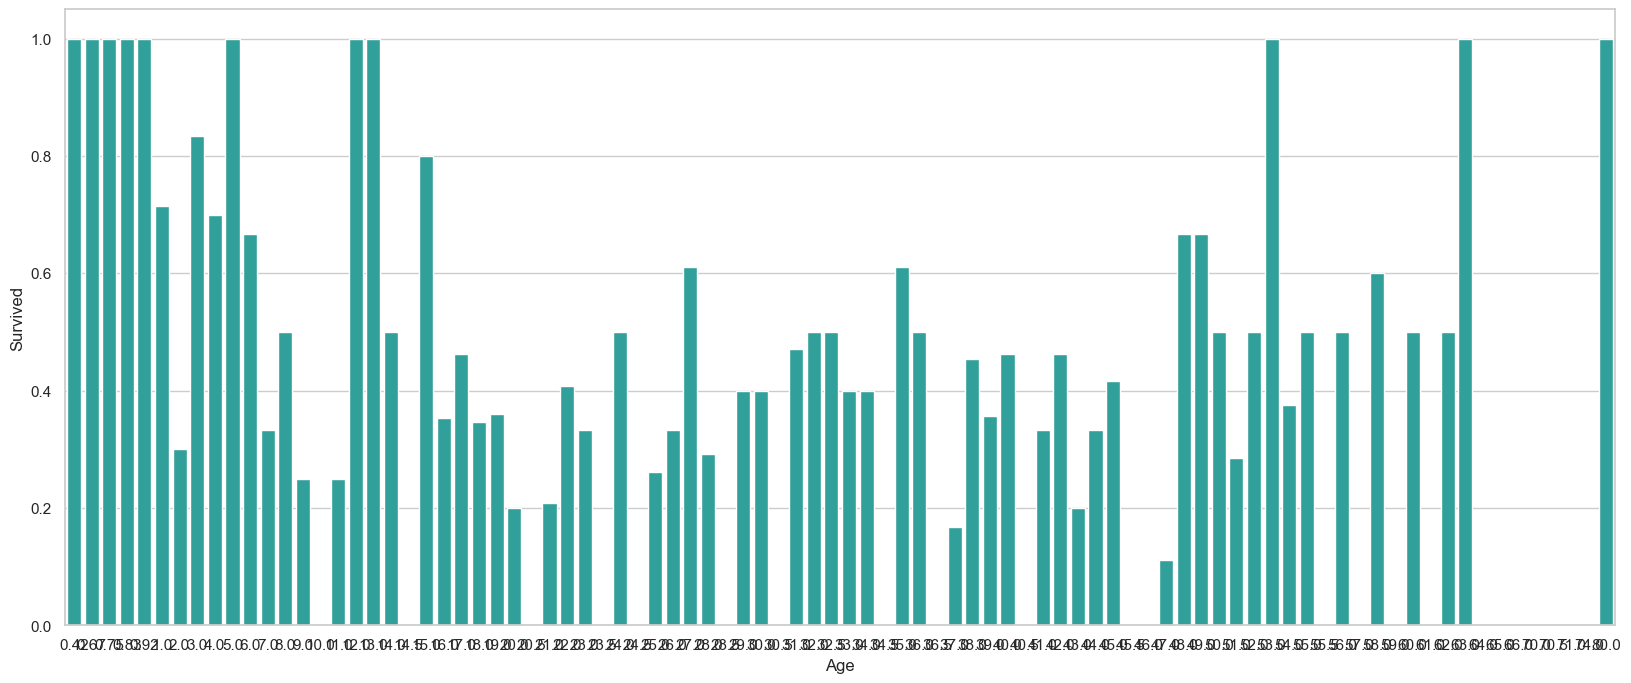

In [ ]:
plt.figure(figsize=(20,8))
avg_survival_byage = final_train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

In [ ]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

3.2. Exploration of Fare
3.2. Exploración de tarifas

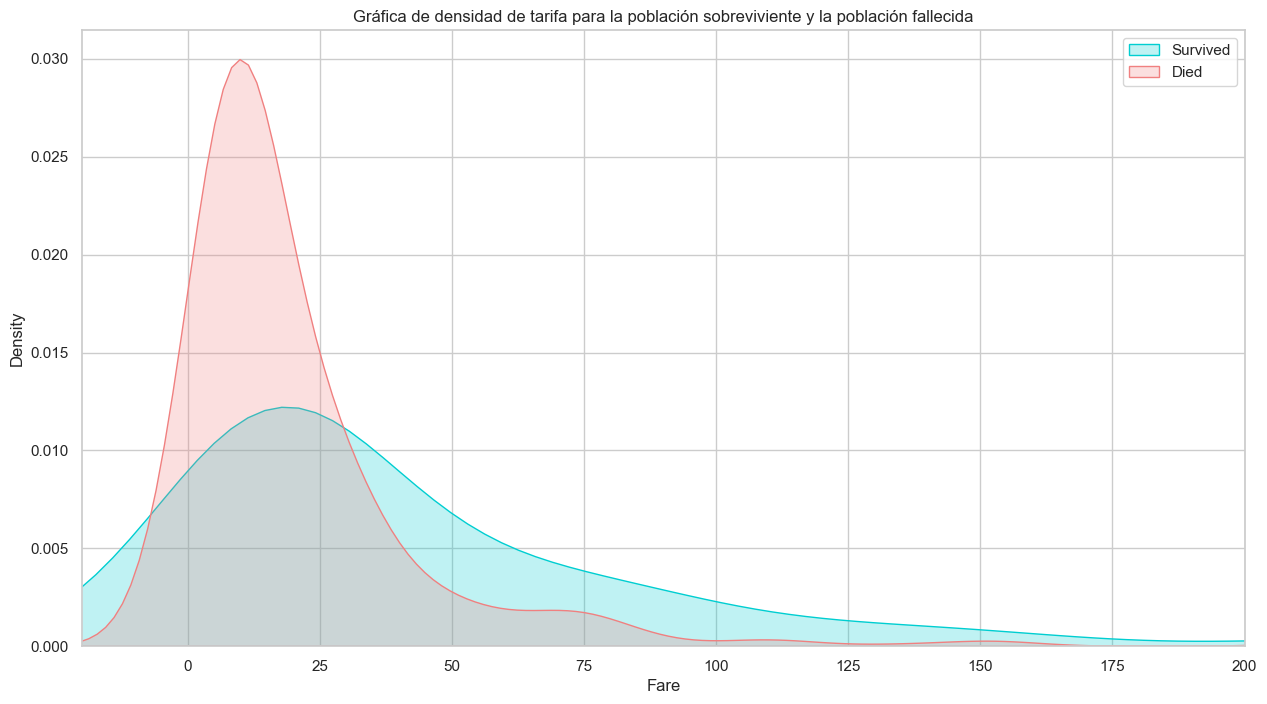

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Gráfica de densidad de tarifa para la población sobreviviente y la población fallecida')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

Como las distribuciones son claramente diferentes para las tarifas de los sobrevivientes frente a las de los fallecidos, es probable que esto sea un predictor significativo en nuestro modelo final. Los pasajeros que pagaron tarifas más bajas parecen haber tenido menos probabilidades de sobrevivir. Probablemente esto esté fuertemente correlacionado con la clase de pasajero, que veremos a continuación.

In [ ]:
3.3. Exploration of Passenger Class



SyntaxError: invalid syntax (3282483110.py, line 1)

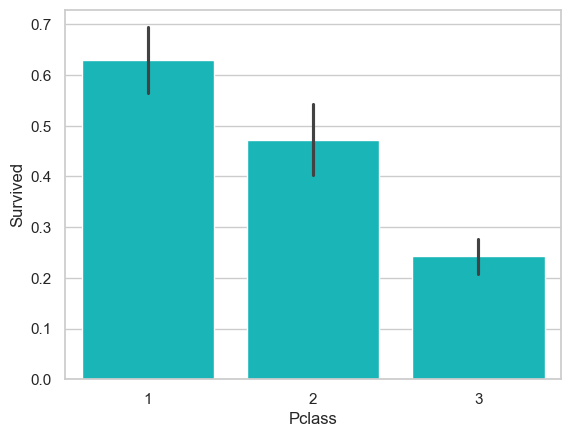

In [ ]:
sns.barplot(x='Pclass', y= 'Survived', data=train_df, color="darkturquoise")
plt.show()

3.4. Exploration of Embarked Port

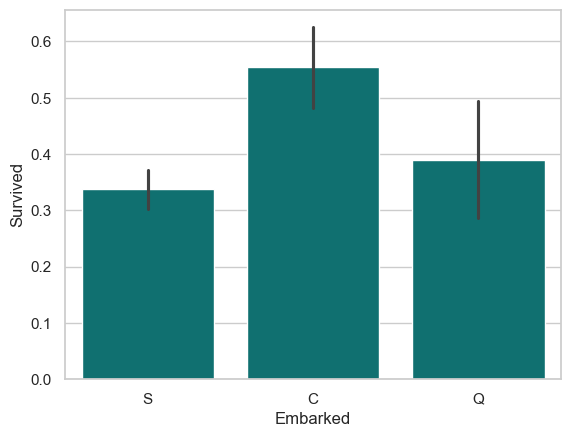

In [ ]:
sns.barplot(x='Embarked', y= 'Survived', data=train_df, color="teal")
plt.show()

Los pasajeros que embarcaron en Cherburgo, Francia, parecen tener la tasa de supervivencia más alta. Los pasajeros que abordaron en Southhampton tenían ligeramente menos probabilidades de sobrevivir que los que abordaron en Queenstown. Esto probablemente esté relacionado con la clase de pasajeros, o tal vez incluso con el orden de las asignaciones de habitaciones (por ejemplo, tal vez los pasajeros anteriores tenían más probabilidades de tener habitaciones más cerca de la cubierta).
También vale la pena señalar el tamaño de los bigotes en estas parcelas. Debido a que el número de pasajeros que abordaron en Southhampton fue mayor, la confianza en torno a la tasa de supervivencia es la más alta. El bigote del gráfico de Queenstown incluye el promedio de Southhampton, así como el límite inferior de su bigote. Es posible que los pasajeros de Queenstown tuvieran la misma desgracia, o incluso más, que sus homólogos de Southhampton.

3.5. Exploration of Traveling Alone vs. With Family

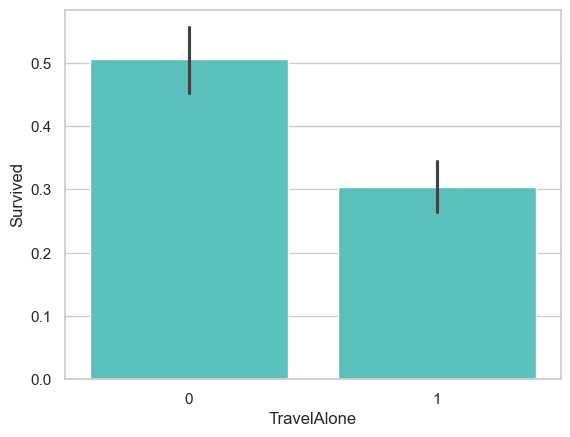

In [ ]:
sns.barplot(x='TravelAlone', y='Survived', data=final_train, color="mediumturquoise")
plt.show()

Las personas que viajaban sin familiares tenían más probabilidades de morir en el desastre que aquellas con familiares a bordo. Dada la época, es probable que las personas que viajaban solas fueran hombres.

3.6. Exploration of Gender Variable

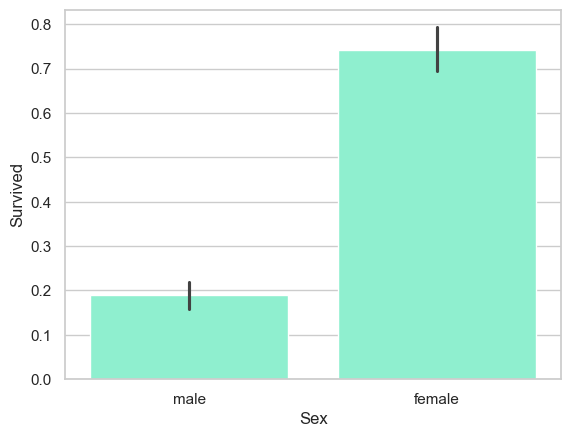

In [ ]:
sns.barplot(x='Sex', y='Survived', data=train_df, color="aquamarine")
plt.show()


Ésta es una diferencia muy obvia. Claramente, ser mujer aumentaba enormemente tus posibilidades de supervivencia.

4. Logistic Regression and Results

4.1. Selección de características¶

4.1.1. Eliminación de funciones recursivas
Dado un estimador externo que asigna pesos a las características, la eliminación recursiva de características (RFE) consiste en seleccionar características considerando recursivamente conjuntos de características cada vez más pequeños. Primero, el estimador se entrena en el conjunto inicial de características y la importancia de cada característica se obtiene a través de un atributo coef_ o mediante un atributo feature_importances_. Luego, las funciones menos importantes se eliminan del conjunto de funciones actual. Ese procedimiento se repite recursivamente en el conjunto eliminado hasta que finalmente se alcanza el número deseado de funciones para seleccionar.

Referencias:
http://scikit-learn.org/stable/modules/feature_selection.html

In [28]:
final_train.columns

Index(['Survived', 'Age', 'Fare', 'TravelAlone', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_male'],
      dtype='object')

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']
# print(X)
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(estimator=model, n_features_to_select=8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes   # resumir la selección de los atributos
print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 'Embarked_S', 'Sex_male', 'IsMinor']


4.1.2. Feature ranking with recursive feature elimination and cross-validation
RFECV performs RFE in a cross-validation loop to find the optimal number or the best number of features. Hereafter a recursive feature elimination applied on logistic regression with automatic tuning of the number of features selected with cross-validation.

4.1.2. Clasificación de funciones con eliminación recursiva de funciones y validación cruzada
RFECV realiza RFE en un bucle de validación cruzada para encontrar el número óptimo o el mejor número de características. De ahora en adelante, se aplicará una eliminación de características recursiva en regresión logística con ajuste automático del número de características seleccionadas con validación cruzada.

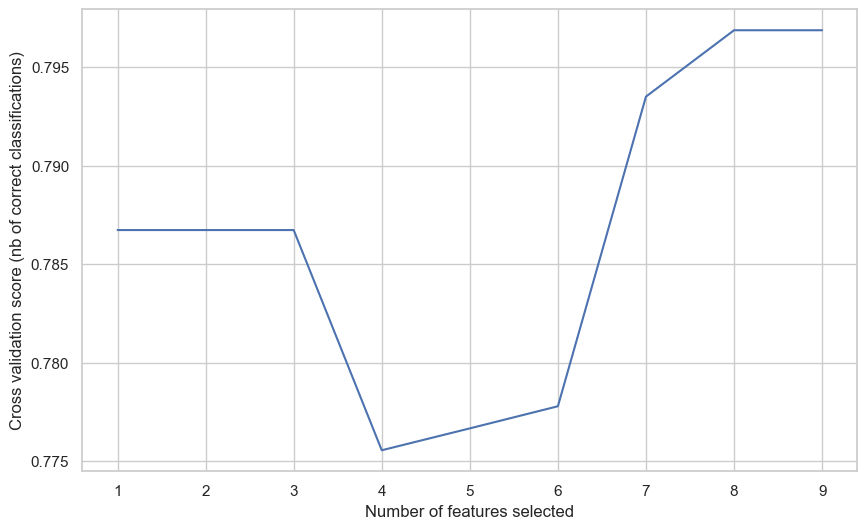

In [81]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

# print("Optimal number of features: %d" % rfecv.n_features_)
# print('Selected features: %s' % list(X.columns[rfecv.support_]))
dicrfecv = rfecv.cv_results_
# print(dicrfecv['mean_test_score'])
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(dicrfecv['mean_test_score']) + 1), dicrfecv['mean_test_score'])
plt.show()

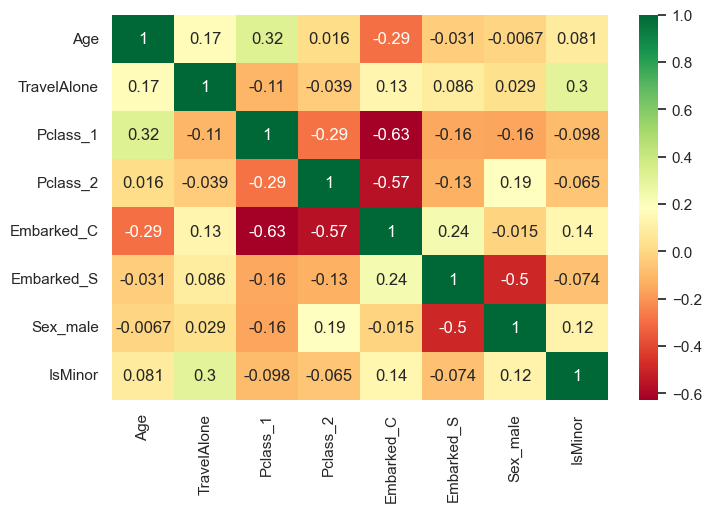

In [82]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()